<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/shawnrhoads/gu-psyc-347/blob/master/docs/solutions/module-04-01_Prosocial-RL-Exercises-Solutions.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

# Prosocial RL Exercises Solutions

We will now fit your behavioral data to the models developed during class (as well as a few others) and then compare the models to assess which model best explains the data. This exercise is a bit different from previous exercises. I will only provide you with minimal code/text to guide you through, but you should be able to complete it all on your own using the course resources, previous tutorials/exercises, previous papers, and previous lectures!

**Once you complete this exercise, you will be well on your way to becoming a pro computational modeler!**

<hr width=50%>

Please download the data from [GitHub](), Canvas, or by using the following code

In [ ]:
import os, requests

# create list of URLs
urls = [f'https://raw.githubusercontent.com/shawnrhoads/gu-psyc-347/master/docs/static/data/{x:02}_psyc-347-prosocial-learning.csv' for x in range(1,11)]

# loop through list and download data
for url in urls:
    r = requests.get(url, allow_redirects=True)
    if os.path.isdir('static/data'):
        filename = 'static/data/' + os.path.basename(url)
    else:
        filename = os.path.basename(url)
    open(filename, 'wb').write(r.content)

Import relevant modules

In [1]:
from scipy.optimize import minimize # finding optimal params in models
from scipy import stats             # statistical tools
import os                           # operating system tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
import ipywidgets as widgets        # interactive display
import matplotlib.pyplot as plt     # plotting
%matplotlib inline

np.random.seed(2021)                # set seed for reproducibility

In [2]:
# this function will load the data into memory (assuming that
# the data are downloaded)
def load_subjects():
    '''
    input: n/a
    output: dictionary of DataFrames containing the data
    '''
        
    if os.path.isdir('static/data'):
        files = [f'static/data/{x:02}_psyc-347-prosocial-learning.csv' for x in range(1,11)]
    else:
        files = [f'{x:02}_psyc-347-prosocial-learning.csv' for x in range(1,11)]
    
    subject_data = {}
    for index, file in enumerate(files):
        df = pd.read_csv(file, index_col='subject')
        subject_data[index] = df_filtered = df[df['outcomeDescr'] != 'practice'][['block',
                                                                                  'trial_num',
                                                                                  'true_accuracy',
                                                                                  'outcome',
                                                                                  'outcomeDescr',
                                                                                  'cumulativePts_self',
                                                                                  'cumulativePts_social']]
        
    return subject_data

In [3]:
# let's load in our data using the function above
# feel free to adjust `how_many` (the default is all 11 subjects)
subject_data = load_subjects()

## Data 

#### 4 conditions/blocks
- self, win
- self, avoid loss
- social, win
- social, avoid loss

#### Each block contains 24 trials
- 2 stimuli per trial (counterbalanced wrt side)
- outcomes associated with each stimulus is probabilistic (75%, 25%)

#### Data output key
- `condition`: (play for self); (play for next participant)
- `goal`: (win) or (avoid loss)
- `trial_num`: order in which trials are displayed within a block (0-23)
- `true_accuracy`: 1 if selected stimulus with highest probability of winning or avoid losing
- `outcome`: outcome for trial (`+1`, `0`, `-1`); blank if missed
- `outcomeDescr`: text description of outcome (practice, social win, social avoid win, social loss, social avoidloss, self win, self avoid win, self loss, self avoidloss)
- `cumulativePts_self`: running total of points for self
- `cumulativePts_social`: running total of points for social

In [4]:
# view data from first subject
display(subject_data[0])

,block,trial_num,true_accuracy,outcome,outcomeDescr,cumulativePts_self,cumulativePts_social
subject,,,,,,,
1.0,social_win,0,0.0,0.0,social avoid win,1000,1000
1.0,social_win,1,1.0,1.0,social win,1000,1100
1.0,social_win,2,1.0,1.0,social win,1000,1200
1.0,social_win,3,1.0,1.0,social win,1000,1300
1.0,social_win,4,1.0,0.0,social avoid win,1000,1300
...,...,...,...,...,...,...,...
1.0,self_avoidloss,19,1.0,0.0,self avoid loss,2100,1300
1.0,self_avoidloss,20,1.0,0.0,self avoid loss,2100,1300
1.0,self_avoidloss,21,1.0,0.0,self avoid loss,2100,1300


<hr width=50%>

In [5]:
def get_index_positions(list_of_elems, element):
    ''' Returns the indexes of all occurrences of give element in
    the list- listOfElements '''
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            # Search for item in list from indexPos to the end of list
            index_pos = list_of_elems.index(element, index_pos)
            # Add the index position in list
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
            
    return index_pos_list

## Define models

In [9]:
# Completed
def Simple_1a1t(params, choices, outcomes, block, plot=False):
    '''
    Inputs:
        - params: list of 2 guesses (float) for each parameter (alpha, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha, theta = params 
    
    if np.isnan(alpha) or np.isnan(theta): # check inputs
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c, r = np.array(choices)[cur_indices], np.array(outcomes)[cur_indices]

            # check if self vs social
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    #don't update
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]
                    Q[int(c[t])] = Q[int(c[t])] + alpha * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

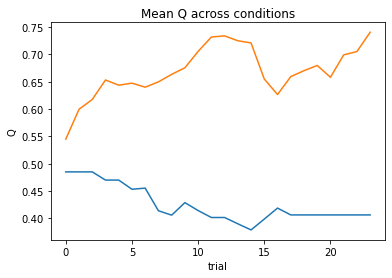

In [10]:
# example for testing function
behavior = subject_data[9]
params = [.12,2.11]
choices, outcomes, block = behavior.true_accuracy, behavior.outcome, behavior.block
subj_negll = Simple_1a1t(params, choices, outcomes, block, plot=True)

In [ ]:
# Completed
def Social_1a1t(params, choices, outcomes, block, plot=False):
    # 1 alpha_self (where alpha_other = 1 - alpha_self) + 1 theta
    '''
    Inputs:
        - params: list of 2 guesses (float) for each parameter (alpha, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha_self, theta = params 
    alpha_other = 1 - alpha_self
    
    if np.isnan(alpha_self) or np.isnan(theta): # check inputs
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c, r = np.array(choices)[cur_indices], np.array(outcomes)[cur_indices]

            # check if self vs social
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r]) 
                
                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    #don't update
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]
                    
                    if 'self' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_self * delta
                    elif 'social' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_other * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

In [ ]:
# Model1 (8 out of 30 points)
def Social_2a1b1t(params, choices, outcomes, block, plot=False):
    # 1 alpha_self + 1 alpha_other + 1 beta + 1 theta
    '''
    Inputs:
        - params: list of 4 guesses (float) for each parameter (alpha, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha_self, alpha_other, beta, theta = params 
    
    if np.isnan(alpha_self) or np.isnan(theta): # check inputs
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c, r = np.array(choices)[cur_indices], np.array(outcomes)[cur_indices]

            # check if self vs social
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r]) 
                
                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    #don't update
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = beta * r[t] - Q[int(c[t])]
                    
                    if 'self' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_self * delta
                    elif 'social' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_other * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

In [ ]:
# Model2 (8 out of 30 points)
def Valence_2a1t(params, choices, outcomes, block):
    # 1 alpha_positive + 1 alpha_negative + 1 theta
    '''
    Inputs:
        - params: list of 3 guesses (float) for each parameter (alpha, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha_positive, alpha_negative, theta = params 
    
    if np.isnan(alpha_self) or np.isnan(theta): # check inputs
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c, r = np.array(choices)[cur_indices], np.array(outcomes)[cur_indices]

            # check if self vs social
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r]) 
                
                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    #don't update
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = beta * r[t] - Q[int(c[t])]
                    
                    if 'win' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_positive * delta
                    elif 'avoidloss' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_negative * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

In [ ]:
# Model3 (8 out of 30 points)
def Social_1a2b1t(params, choices, outcomes, block, plot=False):
    # 1 alpha + 1 beta_self + 1 beta_other + 1 theta
    '''
    Inputs:
        - params: list of 4 guesses (float) for each parameter (alpha, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha, beta_self, beta_other, theta = params 
    
    if np.isnan(alpha_self) or np.isnan(theta): # check inputs
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c, r = np.array(choices)[cur_indices], np.array(outcomes)[cur_indices]

            # check if self vs social
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r]) 
                
                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    #don't update
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    if 'self' in condition:
                        delta = beta_self * r[t] - Q[int(c[t])]
                    elif 'social' in condition:
                        delta = beta_other * r[t] - Q[int(c[t])]

                    Q[int(c[t])] = Q[int(c[t])] + alpha * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

In [ ]:
# Bonus (not required for exercise)
def SocialValence_4a1t(params, choices, outcomes, block, plot=False):
    # 1 alpha_self_pos + 1 alpha_self_neg +
    # 1 alpha_other_pos + 1 alpha_other_neg + 1 theta
    '''
    Inputs:
        - params: list of 5 guesses (float) for each parameter (alpha, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha_self_pos, alpha_self_neg, alpha_other_pos, alpha_other_neg, theta = params 
    
    if np.isnan(alpha_self_pos) or np.isnan(alpha_self_neg) or np.isnan(alpha_other_pos) or np.isnan(alpha_other_neg) or np.isnan(theta): # check inputs
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c, r = np.array(choices)[cur_indices], np.array(outcomes)[cur_indices]

            # check if self vs social
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r]) 
                
                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    #don't update
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]

                    if 'self' in condition:
                        if 'win' in condition:
                            Q[int(c[t])] = Q[int(c[t])] + alpha_self_pos * delta
                        elif 'avoidloss' in condition:
                            Q[int(c[t])] = Q[int(c[t])] + alpha_self_neg * delta

                    elif 'social' in condition:
                        if 'win' in condition:
                            Q[int(c[t])] = Q[int(c[t])] + alpha_other_pos * delta
                        elif 'avoidloss' in condition:
                            Q[int(c[t])] = Q[int(c[t])] + alpha_other_neg * delta                    

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

In [ ]:
# Compute BIC for each Model and Plot (6 out of 30 points)
def calculate_bic(n, nll, num_params):
    bic = -2 * nll + num_params * np.log(n)
    return bic

def plot_bic(df0a, df0b, df1, df2, df3):
    # 96 trials across 11 subjects
    all_num_trials = 96 * 11

    #init list to input bic values
    Bic_list = []

    all_mods = [df0a, df0b, df1, df2, df3]
    all_num_params = [2, 2, 4, 3, 4]

    # get integrated BIC for each model
    for mod, num_params in zip(all_mods, all_num_params):
        bic_temp = calculate_bic(n= all_num_trials, nll=np.nansum(mod['NLL'].values), num_params=num_params)
        bic_list.append(bic_temp)

    #plot these values:
    plt.bar(range(0,len(all_mods)), bic_list)
    plt.xlabel("Model")
    plt.ylabel("BIC Score")
    plt.title("BIC Scores for Different Models")

    plt.xticks(range(0,len(all_mods)), ["df0a", "df0b", "df1", "df2", "df3"])
    plt.show()
